## 使用信息熵寻找最优划分   

### 首先使用sklearn中的决策树模型进行数据划分   

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

In [3]:
iris = datasets.load_iris()

X = iris.data[:, 2:]
y = iris.target

In [4]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(max_depth=2, criterion='entropy')
dt_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

/Users/barackbao/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


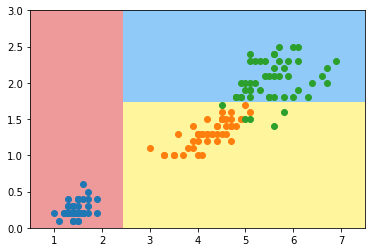

In [5]:
def plot_decision_boundary(model, axis):
    """
    axis指定了两个坐标轴的取值范围
    """
    # 构成一个二维表格
    x0, x1 = np.meshgrid(
        np.linspace(axis[0], axis[1], int((axis[1] - axis[0]) * 100)).reshape(-1, 1),
        np.linspace(axis[2], axis[3], int((axis[3] - axis[2]) * 100)).reshape(-1, 1)
    )
    
    # np.ravel将多维数据降成一维，并且会返回一个引用（类似C++）
    X_new = np.c_[x0.ravel(), x1.ravel()]
    y_predict = model.predict(X_new)
    zz = y_predict.reshape(x0.shape)
    
    from matplotlib.colors import ListedColormap  
    custom_cmap = ListedColormap(['#EF9A9A', '#FFF59D', '#90CAF9'])
    plt.contourf(x0, x1, zz, linewidth=5, cmap=custom_cmap)
    
plot_decision_boundary(dt_clf, [0.5, 7.5, 0, 3])
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])
plt.scatter(X[y==2, 0], X[y==2, 1])
plt.show()

## 模拟使用信息熵进行划分   

In [6]:
def split(X, y, d, value):
    """该函数只负责对给定的特征维度index和对应的划分阈值value对输入的数据集X，y进行划分，
        划分的结果是左右两颗子树
    """    
    # 先确定左右两颗子树中元素在原始数据集中的index
    # 左子树中的元素都是对应d特征维度上小于阈值value的样本点，这样会得到一个bool类型的index矩阵
    index_a = (X[:, d] <= value)
    # 右子树中的元素都是对应d特征维度上大于阈值value的样本点 
    index_b = (X[:, d] > value)
    # 返回左右子树的样本点和对应的样本标签
    return X[index_a], X[index_b], y[index_a], y[index_b]

In [7]:
from collections import Counter
from math import log

def entropy(y):
    # 首先对传入的数据划分统计各个类别出现的次数 
    counter = Counter(y)
    res = 0.0
    for i in counter.values():
        p = i / len(y)
        res += -p * log(p)
    return res
    

def try_split(X, y):
    """
    对于给定的数据集X，y，使用信息熵作为指标，寻找到最佳的分类特征维度d和分类阈值v，将X，y划分成左右两颗子树  
    
    其实本质上就是一个搜索工作，在给定的一定的特征维度范围和分类阈值范围内寻找到熵值最小的划分参数  
    """
    best_entropy = float('inf')
    best_d, best_v = -1, -1
    # 首先遍历特征维度d
    for d in range(X.shape[1]):
        # 然后遍历阈值范围，我们可以先对当前特征维度上的样本值进行排序,或者拿到样本排序的index值
        sorted_index = np.argsort(X[:, d])
        # 然后选取两两样本值的中值作为划分阈值   
        for i in range(1, len(X)):
            # 如果前后两个样本值相同，那求他们的中值对划分也没有意义,所以这里做一下判断
            if X[sorted_index[i-1], d] != X[sorted_index[i], d]:
                v = (X[sorted_index[i-1], d] + X[sorted_index[i], d]) / 2
                # 接下来按照当前d和v来进行决策树的划分 
                X_l, X_r, y_l, y_r = split(X, y, d, v)
                # 然后计算当前划分子树的信息熵值
                e = entropy(y_l) + entropy(y_r)
                # 然后进行参数的更新
                if e < best_entropy:
                    best_entropy, best_d, best_v = e, d, v
    return best_entropy, best_d, best_v

In [8]:
best_entropy, best_d, best_v = try_split(X, y)
print('best_entropy = ', best_entropy)
print('best_d = ', best_d)
print('best_v = ', best_v)

best_entropy =  0.6931471805599453
best_d =  0
best_v =  2.45


我们可以根据上面的划分结果到上面的决策边界图进行对比，划分的维度为0，对应到图就是在横轴上进行划分，并且划分的位置也是2.45这个位置    

然后根据上一步得到的一些划分参数对数据集进行划分，并且计算划分后左右子树各自的熵值  

In [9]:
X1_l, X1_r, y1_l, y1_r = split(X, y, best_d, best_v)

In [10]:
# 计算左子树的熵
entropy(y1_l)

0.0

从划分结果图可以看出第一次划分成功的将一类数据完全划分出来，所以此时这类数据的熵值就为0   

In [11]:
# 计算右子树的熵
entropy(y1_r)

0.6931471805599453

然后我们对右子树继续向下划分，然后计算划分的参数与上面的划分结果图进行对比

In [12]:
best_entropy2, best_d2, best_v2 = try_split(X1_r, y1_r)
print('best_entropy = ', best_entropy2)
print('best_d = ', best_d2)
print('best_v = ', best_v2)

best_entropy =  0.4132278899361904
best_d =  1
best_v =  1.75


此时的划分特征维度是1，对应这上图的y轴，同时划分的阈值也是1.75  

In [14]:
X2_l, X2_r, y2_l, y2_r = split(X1_r, y1_r, best_d2, best_v2)

# 计算第二次划分后左子树的熵
entropy(y2_l)

0.30849545083110386

In [15]:
# 计算第二次划分后右子树的熵
entropy(y2_r)

0.10473243910508653

左右子树的熵均不为0，所以仍可以继续向下划分  